# Convolutioneel Neural Network
*Door: Luuk Bouwman - 1759898*

Klas: V2A

## Voorbereiding

In [ ]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import timeit
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, schedules
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import utils  
from keras.regularizers import L1

## Data Preparation

In [ ]:
# Data inladen
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("X_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", x_test.shape)
print("y_test shape", y_test.shape)

#### Visualize data

In [ ]:
# plot afbeeldingen
fig, ax = plt.subplots(5, 5)
k = 0
 
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(x_train[k], aspect='auto')
        k += 1
 
plt.show()

In [ ]:
x_head, *tail = x_train
y_head, *tail = y_train

In [ ]:
x_head

De shape van de data is 32 x 32 x 3. Waarbij de 32 x 32 het aantal pixels aangeeft en de 3 voor de RGB waardes tussen 0 en 255.

In [ ]:
y_head

Zoals je ziet is de target head een getal. Elk getal staat voor een ander dier of vervoersmiddel.
- 0: vliegtuig
- 1: auto
- 2: vogel
- 3: kat
- 4: hert
- 5: hond
- 6: kikker
- 7: paard
- 8: boot
- 9: vrachtwagen

Dus `x_head` zijn alle pixelwaardes (veranderd naar een getal tussen 0 en 1) van een kikker.

In [ ]:
plt.imshow(x_head, aspect='auto')

### Features

In [ ]:
# datatype aanpassen

x_train = x_train.astype(np.float32) 
x_test = x_test.astype(np.float32)

In [ ]:
# deel pixel waardes door 255 zodat deze tussen 0 en 1 zitten
x_train, x_test = x_train / 255, x_test / 255

### Targets

In [ ]:
# flatten de label values
y_train, y_test = y_train.flatten(), y_test.flatten()

In [ ]:
y_train[:5]

#### Lees verder tot Baseline model Compiler

In [ ]:
# # number of classes
# K = len(set(y_train))

# print("number of classes:", K)

# y_train = utils.to_categorical(y_train, K)
# y_test = utils.to_categorical(y_test, K)

# print(f"Y_train: {y_train.shape}, Y_test: {y_test.shape}")

In [ ]:
def dummies():
    k = len(set(y_train)) # aantal classes
    y_train = utils.to_categorical(y_train, k)
    y_train = utils.to_categorical(y_train, k)
    print(y_train.shape(), y_test.shape())

In [ ]:
# dummies()

## Baseline model
We starten met een baseline model om een accuracy score te vinden die verbeterd moet worden.

We gebruiken hiervoor de architectuur die Nielsen gebruikt heeft in een eerdere MNIST opdracht.

In [ ]:
baseline = Sequential([
    Flatten(input_shape=(32,32,3)), # maakt er 1d array van
    Dense(512, activation="sigmoid"), # past de sigmoid functie: sigmoid(input) = 1 / (1 + exp(-input))
    Dropout(0.2), # onder 0.2 => 0 en boven 0.2 => 1 (Tegen overfitting)
    Dense(512, activation="sigmoid"),
    Dropout(0.2),
    Dense(10, activation="softmax"), # alle getallen worden veranderd zodat ze gezamelijk 1 en zijn en niet negatief
                                     # kan gebruikt worden als kansverdeling
])

### Compiler
Bij de compiler zijn er meerdere hyperparameters om te kiezen. 
_(SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl)_

SGD is een goede optie aangezien dit een 'Gradient descent' optimizer is. (Met een standaard momentum van 0)
Hier gebruikt de architectuur Nielsen de 'Adam' optimizer dus zullen wij dit ook doen.
De Adam optimizer is een soort willekeurige kansverdeling gradient descent methode op de veranderende schattingen.

Verder kan je de loss functie kiezen. _(sparse_categorical_crossentropy OR categorical_crossentropy)_
Gebruik `sparse_categorical_crossentropy` op het moment dat de target al genummerd geclassificeerd is in een 1d array.
of gebruik `categorical_crossentropy` als je de target hebt om gezet naar een 2d (_ x 10) array als een soort 'git_dummies()' dit gebeurd bij `dummies()`.

In [ ]:
baseline.compile(optimizer="Adam", # met standaard learning rate van 0.001
                loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy OR categorical_crossentropy
                metrics=["accuracy"])

#### Fitting
Train het model

In [ ]:
baseline_history = baseline.fit(x_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split = 0.2)

In [ ]:
baseline.evaluate(x_test, y_test)

In [ ]:
y_pred = baseline.predict(x_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print(classification_report(y_test, y_pred_classes))

Hier zie je de:
- __Precision__ *(Precisie van dat het model de juiste soort heeft gekozen)*
- __Recall__ *(Het percentage van correct geclassificeerde van alle instanties die daadwerkelijk positief waren)*
- __F1-score__ *(De F1-score is een gewogen gemiddelde van precision en recall. In het algemeen zijn F1-scores lager dan accuracy omdat ze precision en herinnering beide in de berekingen worden opgenomen)*
- __Support__ *(Het daadwerkelijke aantal verschijningen in de dataset)*
- __Accuracy__ *(Het percentage dat het model de juiste soort kiest)*

In [ ]:
# history van accuracy
plt.plot(baseline_history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
# history van loss
plt.plot(baseline_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## Modellen

### ReLU en Pooling
Nadat we de baseline hebben gaan we het proberen te verbeteren door middel van meerdere Convolution, ReLU en pooling layers toe te voegen om er een echt CNN van te maken.

#### ReLU
ReLU zorgd er voor dat alle getallen onder de 0 worden vervangen door 0.
ReLu wordt vooral gebruikt omdat het eenvoudig, snel en goed lijkt te werken.
Het schijnt namelijk dat het trainen van een netwerk met ReLu in het algemeen veel sneller en betrouwbaarder trainde dan het trainen van een netwerk met sigmoid activatie.

#### Pooling
Maakt de afbeelding kleiner door de hoogste waarde van de pool te nemen als representatie voor alle waardes in de pool.
Zo verklein je de hoeveelheid data en train je in het algemeen veel sneller.

In [ ]:
basic_cnn = Sequential([
    Conv2D(filters=16, activation="relu", kernel_size=(3,3), input_shape=(32, 32, 3)), # filters=16, kernel_size: grote van filter
    MaxPooling2D((2,2)),
    Conv2D(filters=32, activation="relu", kernel_size=(3,3), input_shape=(32, 32, 3)),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(64, activation="relu"),
    Dense(10, activation="softmax")
])

Let op dat ik hier voor de SGD (gradient decent) optimizer ben gegaan.

In [ ]:
basic_cnn.compile(optimizer="SGD", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
basic_cnn.fit(x_train, y_train)

In [ ]:
basic_cnn.evaluate(x_test, y_test)

Hier zie je hoe het na 1 epoch al een enorm voordeel is om deze layers te gebruiken.

#### Batchsize
Batchsize is het aantal samples die het netwerk per keer traint voor het de volgende batch neemt.
##### Voordelen:
- Het kost minder memory om met batches te trainen.
- het netwerkt traint sneller met kleine batches.
##### Nadelen:
- Hoe kleiner de batch how minder accuraat het netwerkt zal zijn.
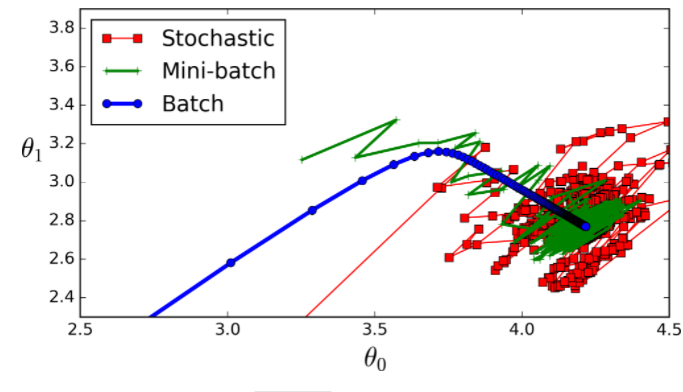
_'Stochastic' is een batch van 1._

In [ ]:
# pas batch_size aan naar voorkeur
batch_size= 1028

In [ ]:
starttime = timeit.default_timer()
history = basic_cnn.fit(x_train, y_train, batch_size= 1028, epochs=1)
print("De tijd het duurde met batch size (", batch_size, ") is:", timeit.default_timer() - starttime)

Uit het onderzoek met verschillende batch sizes als: 1, 16, 32, 64, 128, 256 en geen size. Heb ik er voor gekozen gebruik te maken van een batchsize van 128.

### Weight decay
Weight decay is een goede mannier om overfitting tegen te gaan.
Het zorgt er voor dat je een penalty kan toevoegen voor de weight size ten opzichte van de loss function.
Onder de keras regularizers zijn er 3 weight regularizers:
- L1: Som van de absolute weights.
- L2: Som van de gekwadrateerde weights.
- L1L2: Som van de absolute en de gekwadrateerde weights.

Hieronder heb ik gekozen gebruik te maken van L1

In [ ]:
decay = 0.0005 # 0.0005

In [ ]:
cnn = Sequential([
    Conv2D(filters=16, activation="relu", kernel_size=(3,3), kernel_regularizer=L1(decay), input_shape=(32, 32, 3)),
    MaxPooling2D((2,2)),
    Conv2D(filters=32, activation="relu", kernel_size=(3,3), input_shape=(32, 32, 3)),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(10, activation="softmax")
])

Bij deze optimizer zou ik eerst SGD kiezen. waarna ik zag hoeveel sneller Adam was en die toch koos.

In [ ]:
cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
cnn.summary()

In [ ]:
history = cnn.fit(x_train, y_train, epochs = 10)

In [ ]:
# history van accuracy
plt.plot(baseline_history.history['accuracy'])
plt.plot(baseline_history.history['loss'])
plt.title('model accuracy & loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

_accuracy kan niet boven de 1 aangezien dit meer dan 100% zou zijn_ 

In [ ]:
y_pred = cnn.predict(x_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print(classification_report(y_test, y_pred_classes))

## Conclusie

De qualiteit van het uiteindelijke model is vrij hoog. Aangezien het basicmodel na 1 epoch al een beter resultaat behaald dan het baseline model na 5. Alleen in dit opzichte is het al een beter model. Echter heb ik het model nog niet lang genoeg laten runnen om 90+ accuraccy te halen. Ondanks dat dit zeker mogelijk zal zijn. Voor het geval dat iemand het model wel lang zou laten trainen heb ik dingen als normalisatie en weight decay toegevoegd om overfitting tegen te gaan.

Aangezien we het model op een train set hebben gefit en het nu ook bij de test set ook hoog scored is er geen geval van overfitting.

In [ ]:
cnn.evaluate(x_test, y_test)